In [96]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 500

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [97]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [98]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [99]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [100]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [101]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [102]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [103]:
def create_labels(df, treshold):
    global fee, delta, stop_loss
    def calculate_target(row):
        volatility = (row['Settle']-row['Open'])*delta
        if abs(volatility) > fee + treshold:
            if volatility > 0:
                return 1
                # if row['Open'] - row['Low'] > stop_loss:
                #     return 0
                # else:
                #     return 1
            else:
                return (-1)
                # if row['High'] - row['Open'] > stop_loss:
                #     return 0
                # else:
                #     return (-1)
        else:
            return 0
    df['target'] = df.apply(calculate_target, axis=1)
    # df.target = df.target.shift(-1)
    return df


def create_trade_outcomes(df, contracts):
    global fee, treshold, delta
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [104]:
gold_gains = create_trade_outcomes(gold, 100)
gold_gains.head(20)

            gains     Open     High      Low   Settle
Date                                                 
1996-01-02  342.0  38830.0  39200.0  38800.0  39190.0
1996-01-03  361.0  39240.0  39630.0  39220.0  39620.0
1996-01-04   95.0  39440.0  39580.0  39410.0  39540.0
1996-01-05 -123.5  39780.0  39920.0  39620.0  39650.0
1996-01-09  104.5  39580.0  39710.0  39480.0  39690.0


,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,361.0,39240.0,39630.0,39220.0,39620.0
1996-01-03,95.0,39440.0,39580.0,39410.0,39540.0
1996-01-04,-123.5,39780.0,39920.0,39620.0,39650.0
1996-01-05,104.5,39580.0,39710.0,39480.0,39690.0
1996-01-09,228.0,39780.0,40300.0,39780.0,40020.0
1996-01-10,-66.5,40000.0,40060.0,39880.0,39930.0
1996-01-11,-361.0,40050.0,40090.0,39650.0,39670.0
1996-01-12,133.0,39470.0,39630.0,39400.0,39610.0
1996-01-15,142.5,39730.0,39890.0,39720.0,39880.0


In [105]:
treshold = 275

get_wr(gold, 14)
gold_label = create_labels(gold_gains, treshold)
gold = pd.concat([gold, gold_label[['target']]], axis=1)
# tot, trade = gold.shape[0], gold[gold.target != 0].shape[0]
# print(tot, trade, float(trade/tot))
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,388.3,392.0,388.0,391.9,41453.0,57500.0,2.500000,1
1996-01-03,392.4,396.3,392.2,396.2,102217.0,79518.0,1.204819,0
1996-01-04,394.4,395.8,394.1,395.4,37223.0,83787.0,10.843373,0
1996-01-05,397.8,399.2,396.2,396.5,49601.0,89355.0,24.107143,0
1996-01-09,395.8,397.1,394.8,396.9,27499.0,90634.0,20.535714,0
1996-01-10,397.8,403.0,397.8,400.2,74480.0,103163.0,18.666667,0
1996-01-11,400.0,400.6,398.8,399.3,40319.0,103776.0,24.666667,-1
1996-01-12,400.5,400.9,396.5,396.7,45436.0,97237.0,42.000000,0
1996-01-15,394.7,396.3,394.0,396.1,32344.0,95690.0,46.000000,0


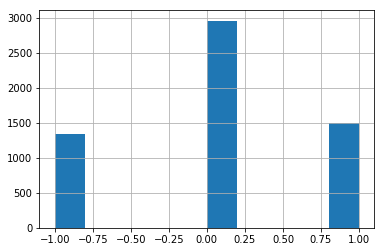

In [11]:
gold['target'].hist()

In [12]:
gold_gains.gains.describe()

count     5780.000000
mean         2.190917
std        903.824695
min     -11390.500000
25%       -237.500000
50%          9.500000
75%        294.500000
max       6555.000000
Name: gains, dtype: float64

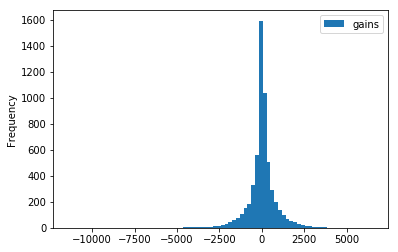

In [13]:
gold_gains[['gains']].plot.hist(bins=80)

In [14]:
gold_gains.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,361.0,39240.0,39630.0,39220.0,39620.0,0.0
1996-01-03,95.0,39440.0,39580.0,39410.0,39540.0,0.0
1996-01-04,-123.5,39780.0,39920.0,39620.0,39650.0,0.0
1996-01-05,104.5,39580.0,39710.0,39480.0,39690.0,0.0
1996-01-09,228.0,39780.0,40300.0,39780.0,40020.0,0.0
1996-01-10,-66.5,40000.0,40060.0,39880.0,39930.0,-1.0
1996-01-11,-361.0,40050.0,40090.0,39650.0,39670.0,0.0
1996-01-12,133.0,39470.0,39630.0,39400.0,39610.0,0.0
1996-01-15,142.5,39730.0,39890.0,39720.0,39880.0,0.0


In [58]:
gold.head(25)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,388.3,392.0,388.0,391.9,41453.0,57500.0,2.500000,0.0
1996-01-03,392.4,396.3,392.2,396.2,102217.0,79518.0,1.204819,0.0
1996-01-04,394.4,395.8,394.1,395.4,37223.0,83787.0,10.843373,0.0
1996-01-05,397.8,399.2,396.2,396.5,49601.0,89355.0,24.107143,0.0
1996-01-09,395.8,397.1,394.8,396.9,27499.0,90634.0,20.535714,0.0
1996-01-10,397.8,403.0,397.8,400.2,74480.0,103163.0,18.666667,-1.0
1996-01-11,400.0,400.6,398.8,399.3,40319.0,103776.0,24.666667,0.0
1996-01-12,400.5,400.9,396.5,396.7,45436.0,97237.0,42.000000,0.0
1996-01-15,394.7,396.3,394.0,396.1,32344.0,95690.0,46.000000,0.0


In [15]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
corn_gains = create_trade_outcomes(corn, 50)
corn_gains.head(5)

              gains     Open     High      Low   Settle
Date                                                   
1996-01-02  106.875  18550.0  18762.5  18512.5  18662.5
1996-01-03   47.500  18650.0  18725.0  18512.5  18700.0
1996-01-04 -213.750  18675.0  18687.5  18250.0  18450.0
1996-01-05  -11.875  18337.5  18450.0  18275.0  18325.0
1996-01-08 -190.000  18225.0  18225.0  18000.0  18025.0


,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5


In [16]:
corn_gains.gains.describe()

count    5789.000000
mean        2.203101
std       310.165899
min     -1983.125000
25%      -118.750000
50%         0.000000
75%       130.625000
max      1888.125000
Name: gains, dtype: float64

5790 1951 0.33696027633851466


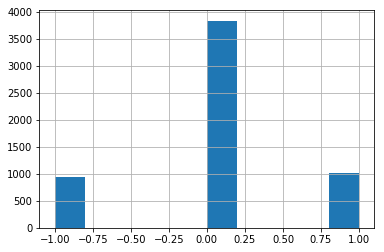

In [17]:
treshold = 200

get_wr(corn, 14)
corn_label = create_labels(corn_gains, treshold)
corn['target'] = corn_label.target
tot, trade = corn.shape[0], corn[corn.target != 0].shape[0]
print(tot, trade, float(trade/tot))

corn.target.hist()

In [18]:
corn.head(5)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,371.00,375.25,370.25,373.25,258495.0,1466855.0,40.000000,-1.0
1996-01-03,373.00,374.50,370.25,374.00,259050.0,1426400.0,25.000000,0.0
1996-01-04,373.50,373.75,365.00,369.00,392195.0,1389390.0,60.975610,0.0
1996-01-05,366.75,369.00,365.50,366.50,245720.0,1359685.0,85.365854,1.0
1996-01-08,364.50,364.50,360.00,360.50,297685.0,1329650.0,96.721311,-1.0


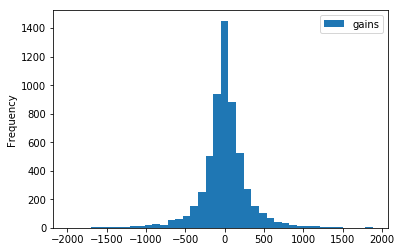

In [19]:
corn_gains[['gains']].plot.hist(bins=40)

In [20]:
corn_gains.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,-1.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,0.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,-1.0
1996-01-09,-249.375,18375.0,18375.0,18100.0,18112.5,-1.0
1996-01-10,-225.625,18112.5,18112.5,17800.0,17875.0,1.0
1996-01-11,237.500,17887.5,18150.0,17887.5,18137.5,0.0
1996-01-12,142.500,18100.0,18262.5,18075.0,18250.0,-1.0


In [21]:
# coffee contract size is 37,500 pounds price is in cents per pound
coffee_gains = create_trade_outcomes(coffee, 375)
coffee_gains.head(5)

                gains     Open      High      Low    Settle
Date                                                       
1996-01-02  -480.9375  34725.0  35550.00  34162.5  34218.75
1996-01-03  1015.3125  34087.5  35400.00  33900.0  35156.25
1996-01-04  1727.8125  34875.0  36787.50  34875.0  36693.75
1996-01-05  -445.3125  36562.5  37293.75  35925.0  36093.75
1996-01-10   890.6250  35775.0  36843.75  35550.0  36712.50


,gains,Open,High,Low,Settle
Date,,,,,
1996-01-02,1015.3125,34087.5,35400.00,33900.00,35156.25
1996-01-03,1727.8125,34875.0,36787.50,34875.00,36693.75
1996-01-04,-445.3125,36562.5,37293.75,35925.00,36093.75
1996-01-05,890.6250,35775.0,36843.75,35550.00,36712.50
1996-01-10,1977.1875,36562.5,38812.50,36468.75,38643.75


In [22]:
coffee_gains.gains.describe()

count     5751.000000
mean        -2.638889
std        968.552015
min     -12842.812500
25%       -213.750000
50%          0.000000
75%        231.562500
max       6929.062500
Name: gains, dtype: float64

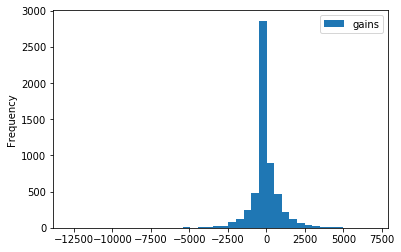

In [23]:
coffee_gains[['gains']].plot.hist(bins=40)

5752 2696 0.46870653685674546


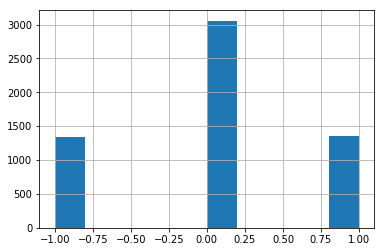

In [24]:
treshold = 275

get_wr(coffee, 14)
coffee_label = create_labels(coffee_gains, treshold)
coffee['target'] = coffee_label.target
tot, trade = coffee.shape[0], coffee[coffee.target != 0].shape[0]
print(tot, trade, float(trade/tot))

coffee.target.hist()

In [25]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,92.60,94.80,91.10,91.25,5719.0,18717.0,95.945946,1.0
1996-01-03,90.90,94.40,90.40,93.75,6461.0,19257.0,23.863636,-1.0
1996-01-04,93.00,98.10,93.00,97.85,8865.0,18918.0,3.246753,1.0
1996-01-05,97.50,99.45,95.80,96.25,6833.0,18599.0,35.359116,1.0
1996-01-11,97.50,103.50,97.25,103.05,10130.0,17662.0,3.435115,-1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,8.550186,1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,36.431227,1.0
1996-01-16,97.75,105.25,97.75,103.90,9918.0,17601.0,9.090909,1.0
1996-01-18,103.80,107.25,102.25,105.40,8355.0,16314.0,10.979228,1.0


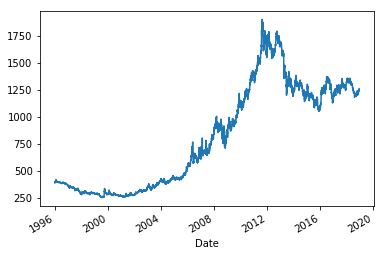

In [26]:
gold['Open'].plot()

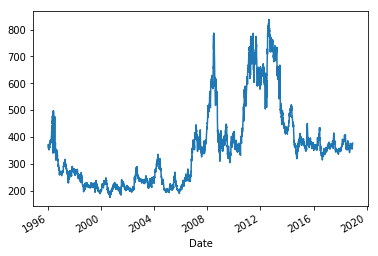

In [27]:
corn['Open'].plot()

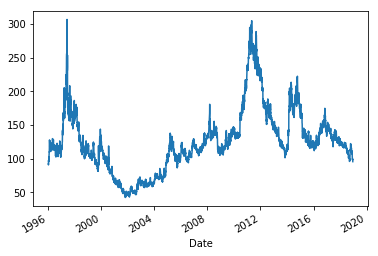

In [28]:
coffee['Open'].plot()

In [29]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [106]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

AttributeError: 'Series' object has no attribute 'wr'

In [ ]:
gold_data.tail(20)

In [ ]:
gold_data.shape

In [ ]:
gold_cot.head(5)

In [ ]:
gold_data = gold_data[gold_data.index >= '2007-01-01']
corn_data = corn_data[corn_data.index >= '2007-01-01']
coffee_data = coffee_data[coffee_data.index >= '2007-01-01']

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


def data_split_pca_transform(df):
    label_index = 3045
    df_validate = df.loc['2016-01-01' <= df.index]
    df_data_tt = df.loc['2016-01-01' > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)

    # pca_lst = []
    pca = PCA(n_components=35, random_state=2234)
    pca.fit(df_train[list(range(3024))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)

    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_data_tt[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3024))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3025,label_index))].values), axis=1)
    return df_pca

In [ ]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [ ]:
gold_label_train.unique()

In [ ]:
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [ ]:
def plot_pca_relation(pca_data, label_train, x):
    labels = [0, 1, -1]
    labl={-1: 'Short', 0:'No Trade', 1:'Long'}
    plt.figure(1)

    for i in range(x):
        for j in range(i+1, x):
            fig, ax = plt.subplots(figsize=(7,5))
            fig.patch.set_facecolor('white')
            Xax = pca_data[:, i]
            Yax = pca_data[:, j]
            for l in labels:
                ix = np.where(label_train==l)
                ax.scatter(Xax[ix], Yax[ix], label=labl[l])

            plt.xlabel("Principal Component No " + str(i), fontsize=14)
            plt.ylabel("Second Principal Component No " + str(j), fontsize=14)
            plt.legend()
            plt.show()

In [ ]:
pca_components = 3

In [ ]:
# plot_pca_relation(gold_pca[0].transform(gold_train[list(range(2016))]), gold_label_train, pca_components)

In [ ]:
# plot_pca_relation(corn_pca[0].transform(corn_train[list(range(2016))]), corn_label_train, pca_components)

In [ ]:
# plot_pca_relation(coffee_pca[0].transform(coffee_train[list(range(2016))]), coffee_label_train, pca_components)

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import lightgbm as lgb
import xgboost as xgb


X = pca_transform(gold_train, gold_pca)
train_data = lgb.Dataset(X, label=list(map(lambda x: x+1, gold_label_train)), categorical_feature='auto') # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x+1, gold_label_test)))
param = {'num_leaves':31, 'objective':'multiclass'}
# param['metric'] = 'auc'
# param['boosting_type'] = 'gbdt'
# param['metric'] = 'rmse'
param['boosting'] = 'dart'
# param['max_bin'] = 50
# param['metric'] = 'multi_error'
param['metric'] = 'multi_logloss'
param['learning_rate'] = 0.05
param['num_class'] = 3
param['max_bin'] = 50
num_round = 500
# param = {'boosting_type': 'gbdt',
#          'max_depth' : -1,
#           'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 64,
#           'learning_rate': 0.05,
#           'max_bin': 512,
#           'subsample_for_bin': 200,
#           'subsample': 1,
#           'subsample_freq': 1,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 5,
#           'reg_lambda': 10,
#           'min_split_gain': 0.5,
#           'min_child_weight': 1,
#           'min_child_samples': 5,
#           'scale_pos_weight': 1,
#           'num_class' : 1,
#           'metric' : 'binary_error'}
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

# gold_clf = RandomForestClassifier(n_estimators=150, random_state=1100)
# gold_clf = AdaBoostClassifier(n_estimators=100, random_state=1100, learning_rate=0.1)
# gold_clf = MLPClassifier(hidden_layer_sizes=(100, 3), solver='sgd', random_state=1100)
# gold_clf = MLPRegressor(hidden_layer_sizes=(100, 3), solver='sgd', max_iter=2000, alpha=0.1, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, gold_label_train))
# gold_clf.fit(X, gold_label_train)
# gold_clf.fit(X, gold_label_train, sample_weight=sample_weight)

[1]	valid_0's multi_logloss: 1.09552
[2]	valid_0's multi_logloss: 1.09281
[3]	valid_0's multi_logloss: 1.09099
[4]	valid_0's multi_logloss: 1.08846
[5]	valid_0's multi_logloss: 1.08664
[6]	valid_0's multi_logloss: 1.08459
[7]	valid_0's multi_logloss: 1.0833
[8]	valid_0's multi_logloss: 1.08382
[9]	valid_0's multi_logloss: 1.0823
[10]	valid_0's multi_logloss: 1.08111
[11]	valid_0's multi_logloss: 1.08085
[12]	valid_0's multi_logloss: 1.08109
[13]	valid_0's multi_logloss: 1.08047
[14]	valid_0's multi_logloss: 1.08054
[15]	valid_0's multi_logloss: 1.08024
[16]	valid_0's multi_logloss: 1.07949
[17]	valid_0's multi_logloss: 1.07884
[18]	valid_0's multi_logloss: 1.07926
[19]	valid_0's multi_logloss: 1.07924
[20]	valid_0's multi_logloss: 1.08052
[21]	valid_0's multi_logloss: 1.08006
[22]	valid_0's multi_logloss: 1.08068
[23]	valid_0's multi_logloss: 1.08133
[24]	valid_0's multi_logloss: 1.0825
[25]	valid_0's multi_logloss: 1.08321
[26]	valid_0's multi_logloss: 1.08434
[27]	valid_0's multi_log

[235]	valid_0's multi_logloss: 1.12688
[236]	valid_0's multi_logloss: 1.12927
[237]	valid_0's multi_logloss: 1.13072
[238]	valid_0's multi_logloss: 1.13157
[239]	valid_0's multi_logloss: 1.13326
[240]	valid_0's multi_logloss: 1.13397
[241]	valid_0's multi_logloss: 1.133
[242]	valid_0's multi_logloss: 1.13452
[243]	valid_0's multi_logloss: 1.13359
[244]	valid_0's multi_logloss: 1.13277
[245]	valid_0's multi_logloss: 1.13347
[246]	valid_0's multi_logloss: 1.13537
[247]	valid_0's multi_logloss: 1.13666
[248]	valid_0's multi_logloss: 1.13569
[249]	valid_0's multi_logloss: 1.13491
[250]	valid_0's multi_logloss: 1.13545
[251]	valid_0's multi_logloss: 1.13465
[252]	valid_0's multi_logloss: 1.13387
[253]	valid_0's multi_logloss: 1.13491
[254]	valid_0's multi_logloss: 1.1365
[255]	valid_0's multi_logloss: 1.13638
[256]	valid_0's multi_logloss: 1.1383
[257]	valid_0's multi_logloss: 1.13973
[258]	valid_0's multi_logloss: 1.14
[259]	valid_0's multi_logloss: 1.13916
[260]	valid_0's multi_logloss: 1

[452]	valid_0's multi_logloss: 1.19754
[453]	valid_0's multi_logloss: 1.19655
[454]	valid_0's multi_logloss: 1.19562
[455]	valid_0's multi_logloss: 1.19711
[456]	valid_0's multi_logloss: 1.19605
[457]	valid_0's multi_logloss: 1.19514
[458]	valid_0's multi_logloss: 1.19632
[459]	valid_0's multi_logloss: 1.19795
[460]	valid_0's multi_logloss: 1.19712
[461]	valid_0's multi_logloss: 1.19841
[462]	valid_0's multi_logloss: 1.19748
[463]	valid_0's multi_logloss: 1.19663
[464]	valid_0's multi_logloss: 1.19765
[465]	valid_0's multi_logloss: 1.19823
[466]	valid_0's multi_logloss: 1.19736
[467]	valid_0's multi_logloss: 1.19881
[468]	valid_0's multi_logloss: 1.19793
[469]	valid_0's multi_logloss: 1.19957
[470]	valid_0's multi_logloss: 1.19862
[471]	valid_0's multi_logloss: 1.1997
[472]	valid_0's multi_logloss: 1.19885
[473]	valid_0's multi_logloss: 1.19973
[474]	valid_0's multi_logloss: 1.2013
[475]	valid_0's multi_logloss: 1.20279
[476]	valid_0's multi_logloss: 1.20196
[477]	valid_0's multi_loglo

In [108]:
X = pca_transform(corn_train, corn_pca)

y = list(map(lambda x: x, corn_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature='auto')
X_test = pca_transform(corn_test, corn_pca)
y_test = list(map(lambda x: x, corn_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')
param = {'num_leaves':31}
param['objective'] = 'binary'
# param['objective'] = 'multiclass'
# param['metric'] = 'auc'
param['metric'] = 'rmse'
# param['metric'] = 'multi_error'
# param['metric'] = 'multi_logloss'
# param['num_class'] = 3
param['max_bin'] = 40
param['learning_rate'] = 0.025
corn_xgb_use = False
# param['categorical_feature'] = 3040,3041,3042,3043
num_round = 2000
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, corn_label_train))
# dtrain = xgb.DMatrix(X, label=list(map(lambda x: x+1, corn_label_train)), weight=sample_weight)
# test_weight = list(map(lambda x: 2 if x != 0 else 1, corn_label_train))
# dtest = xgb.DMatrix(X_test, label=list(map(lambda x: x+1, corn_label_test)), weight=test_weight)
# evallist = [(dtrain, 'train'), (dtest, 'eval')]
# param = {'max_depth': 50, 'eta': 1, 'silent': 1}
# param['booster'] = 'dart'
# param['nthread'] = 3
# param['objective'] = 'multi:softmax'
# param['objective'] = 'reg:linear'
# param['num_class'] = 3
# param['eval_metric'] = 'mlogloss'

# corn_clf = xgb.train(param, dtrain, num_round, evallist)
# corn_clf = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, objective='reg:logistic',
#                              booster='dart', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)
# print(np.unique(list(map(lambda x: (x+1)/2, corn_label_train))))
# corn_clf.fit(X, list(map(lambda x: (x+1)/2, corn_label_train)))

# corn_clf = AdaBoostClassifier(n_estimators=150, learning_rate=0.5, random_state=1100)
# corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# corn_clf = RandomForestClassifier(n_estimators=100, random_state=1100)
sample_weight = list(map(lambda x: 3 if x != 0 else 1, corn_label_train))
# corn_clf.fit(X, corn_label_train)
# corn_clf.predict(X)

[1]	valid_0's rmse: 0.762136
[2]	valid_0's rmse: 0.762234
[3]	valid_0's rmse: 0.762393
[4]	valid_0's rmse: 0.762698
[5]	valid_0's rmse: 0.763013
[6]	valid_0's rmse: 0.76337
[7]	valid_0's rmse: 0.763915
[8]	valid_0's rmse: 0.764427
[9]	valid_0's rmse: 0.764905
[10]	valid_0's rmse: 0.765474
[11]	valid_0's rmse: 0.765942
[12]	valid_0's rmse: 0.766487
[13]	valid_0's rmse: 0.767217
[14]	valid_0's rmse: 0.767825
[15]	valid_0's rmse: 0.768416
[16]	valid_0's rmse: 0.768935
[17]	valid_0's rmse: 0.769609
[18]	valid_0's rmse: 0.770232
[19]	valid_0's rmse: 0.770847
[20]	valid_0's rmse: 0.771256
[21]	valid_0's rmse: 0.771752
[22]	valid_0's rmse: 0.772394
[23]	valid_0's rmse: 0.772991
[24]	valid_0's rmse: 0.773494
[25]	valid_0's rmse: 0.774123
[26]	valid_0's rmse: 0.774843
[27]	valid_0's rmse: 0.775433
[28]	valid_0's rmse: 0.775817
[29]	valid_0's rmse: 0.776358
[30]	valid_0's rmse: 0.776598
[31]	valid_0's rmse: 0.777156
[32]	valid_0's rmse: 0.777723
[33]	valid_0's rmse: 0.778216
[34]	valid_0's rmse:

[306]	valid_0's rmse: 0.813214
[307]	valid_0's rmse: 0.813167
[308]	valid_0's rmse: 0.813089
[309]	valid_0's rmse: 0.812979
[310]	valid_0's rmse: 0.812844
[311]	valid_0's rmse: 0.812834
[312]	valid_0's rmse: 0.812828
[313]	valid_0's rmse: 0.812799
[314]	valid_0's rmse: 0.812903
[315]	valid_0's rmse: 0.812871
[316]	valid_0's rmse: 0.812843
[317]	valid_0's rmse: 0.8129
[318]	valid_0's rmse: 0.812819
[319]	valid_0's rmse: 0.812783
[320]	valid_0's rmse: 0.812727
[321]	valid_0's rmse: 0.812874
[322]	valid_0's rmse: 0.812988
[323]	valid_0's rmse: 0.81296
[324]	valid_0's rmse: 0.812995
[325]	valid_0's rmse: 0.812942
[326]	valid_0's rmse: 0.812873
[327]	valid_0's rmse: 0.812829
[328]	valid_0's rmse: 0.812784
[329]	valid_0's rmse: 0.812863
[330]	valid_0's rmse: 0.812904
[331]	valid_0's rmse: 0.81289
[332]	valid_0's rmse: 0.812764
[333]	valid_0's rmse: 0.812774
[334]	valid_0's rmse: 0.81284
[335]	valid_0's rmse: 0.812948
[336]	valid_0's rmse: 0.812971
[337]	valid_0's rmse: 0.813053
[338]	valid_0

[680]	valid_0's rmse: 0.813333
[681]	valid_0's rmse: 0.813273
[682]	valid_0's rmse: 0.813214
[683]	valid_0's rmse: 0.813287
[684]	valid_0's rmse: 0.813352
[685]	valid_0's rmse: 0.813367
[686]	valid_0's rmse: 0.813305
[687]	valid_0's rmse: 0.8133
[688]	valid_0's rmse: 0.813301
[689]	valid_0's rmse: 0.813384
[690]	valid_0's rmse: 0.813362
[691]	valid_0's rmse: 0.813233
[692]	valid_0's rmse: 0.81327
[693]	valid_0's rmse: 0.813307
[694]	valid_0's rmse: 0.81333
[695]	valid_0's rmse: 0.813345
[696]	valid_0's rmse: 0.813423
[697]	valid_0's rmse: 0.813384
[698]	valid_0's rmse: 0.813283
[699]	valid_0's rmse: 0.813296
[700]	valid_0's rmse: 0.81326
[701]	valid_0's rmse: 0.813318
[702]	valid_0's rmse: 0.813407
[703]	valid_0's rmse: 0.813379
[704]	valid_0's rmse: 0.813434
[705]	valid_0's rmse: 0.813366
[706]	valid_0's rmse: 0.813242
[707]	valid_0's rmse: 0.813229
[708]	valid_0's rmse: 0.813265
[709]	valid_0's rmse: 0.813249
[710]	valid_0's rmse: 0.81315
[711]	valid_0's rmse: 0.813154
[712]	valid_0'

[1054]	valid_0's rmse: 0.81622
[1055]	valid_0's rmse: 0.816178
[1056]	valid_0's rmse: 0.816171
[1057]	valid_0's rmse: 0.816239
[1058]	valid_0's rmse: 0.816299
[1059]	valid_0's rmse: 0.81631
[1060]	valid_0's rmse: 0.816335
[1061]	valid_0's rmse: 0.816298
[1062]	valid_0's rmse: 0.816267
[1063]	valid_0's rmse: 0.816269
[1064]	valid_0's rmse: 0.816284
[1065]	valid_0's rmse: 0.816392
[1066]	valid_0's rmse: 0.816382
[1067]	valid_0's rmse: 0.816303
[1068]	valid_0's rmse: 0.816264
[1069]	valid_0's rmse: 0.816237
[1070]	valid_0's rmse: 0.816255
[1071]	valid_0's rmse: 0.816278
[1072]	valid_0's rmse: 0.816234
[1073]	valid_0's rmse: 0.816209
[1074]	valid_0's rmse: 0.816258
[1075]	valid_0's rmse: 0.816326
[1076]	valid_0's rmse: 0.816368
[1077]	valid_0's rmse: 0.816368
[1078]	valid_0's rmse: 0.816306
[1079]	valid_0's rmse: 0.816218
[1080]	valid_0's rmse: 0.8162
[1081]	valid_0's rmse: 0.81618
[1082]	valid_0's rmse: 0.816222
[1083]	valid_0's rmse: 0.816277
[1084]	valid_0's rmse: 0.81627
[1085]	valid_0

[1401]	valid_0's rmse: 0.818637
[1402]	valid_0's rmse: 0.818568
[1403]	valid_0's rmse: 0.818631
[1404]	valid_0's rmse: 0.81863
[1405]	valid_0's rmse: 0.818665
[1406]	valid_0's rmse: 0.818678
[1407]	valid_0's rmse: 0.818596
[1408]	valid_0's rmse: 0.818682
[1409]	valid_0's rmse: 0.818616
[1410]	valid_0's rmse: 0.818601
[1411]	valid_0's rmse: 0.818537
[1412]	valid_0's rmse: 0.818584
[1413]	valid_0's rmse: 0.818569
[1414]	valid_0's rmse: 0.8186
[1415]	valid_0's rmse: 0.81857
[1416]	valid_0's rmse: 0.818586
[1417]	valid_0's rmse: 0.818588
[1418]	valid_0's rmse: 0.818677
[1419]	valid_0's rmse: 0.818628
[1420]	valid_0's rmse: 0.818607
[1421]	valid_0's rmse: 0.81851
[1422]	valid_0's rmse: 0.818572
[1423]	valid_0's rmse: 0.818639
[1424]	valid_0's rmse: 0.818678
[1425]	valid_0's rmse: 0.818675
[1426]	valid_0's rmse: 0.818778
[1427]	valid_0's rmse: 0.818778
[1428]	valid_0's rmse: 0.818741
[1429]	valid_0's rmse: 0.818791
[1430]	valid_0's rmse: 0.818858
[1431]	valid_0's rmse: 0.81894
[1432]	valid_0

[1803]	valid_0's rmse: 0.822694
[1804]	valid_0's rmse: 0.822669
[1805]	valid_0's rmse: 0.822737
[1806]	valid_0's rmse: 0.822823
[1807]	valid_0's rmse: 0.822874
[1808]	valid_0's rmse: 0.822886
[1809]	valid_0's rmse: 0.822866
[1810]	valid_0's rmse: 0.822921
[1811]	valid_0's rmse: 0.82287
[1812]	valid_0's rmse: 0.822882
[1813]	valid_0's rmse: 0.822866
[1814]	valid_0's rmse: 0.822841
[1815]	valid_0's rmse: 0.822807
[1816]	valid_0's rmse: 0.822881
[1817]	valid_0's rmse: 0.822901
[1818]	valid_0's rmse: 0.822917
[1819]	valid_0's rmse: 0.822882
[1820]	valid_0's rmse: 0.82295
[1821]	valid_0's rmse: 0.823037
[1822]	valid_0's rmse: 0.823072
[1823]	valid_0's rmse: 0.823094
[1824]	valid_0's rmse: 0.823172
[1825]	valid_0's rmse: 0.823222
[1826]	valid_0's rmse: 0.823261
[1827]	valid_0's rmse: 0.823277
[1828]	valid_0's rmse: 0.823269
[1829]	valid_0's rmse: 0.82324
[1830]	valid_0's rmse: 0.823265
[1831]	valid_0's rmse: 0.823304
[1832]	valid_0's rmse: 0.823405
[1833]	valid_0's rmse: 0.823397
[1834]	vali

In [109]:
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=list(map(lambda x: x+1, coffee_label_train)),) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x+1, coffee_label_test)))
param = {'num_leaves':31, 'objective':'multiclass'}
param['booster'] = 'dart'
param['metric'] = 'rmse'
param['metric'] = 'multi_logloss'
param['num_class'] = 3
param['max_bin'] = 50
num_round = 100
# coffee_clf = lgb.train(X, label=coffee_label_train)
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's multi_logloss: 1.09601
[2]	valid_0's multi_logloss: 1.09624
[3]	valid_0's multi_logloss: 1.09701
[4]	valid_0's multi_logloss: 1.09773
[5]	valid_0's multi_logloss: 1.0967
[6]	valid_0's multi_logloss: 1.0961
[7]	valid_0's multi_logloss: 1.09685
[8]	valid_0's multi_logloss: 1.09684
[9]	valid_0's multi_logloss: 1.098
[10]	valid_0's multi_logloss: 1.09809
[11]	valid_0's multi_logloss: 1.09893
[12]	valid_0's multi_logloss: 1.10076
[13]	valid_0's multi_logloss: 1.10236
[14]	valid_0's multi_logloss: 1.10392
[15]	valid_0's multi_logloss: 1.10463
[16]	valid_0's multi_logloss: 1.10461
[17]	valid_0's multi_logloss: 1.1073
[18]	valid_0's multi_logloss: 1.10881
[19]	valid_0's multi_logloss: 1.1095
[20]	valid_0's multi_logloss: 1.1129
[21]	valid_0's multi_logloss: 1.11421
[22]	valid_0's multi_logloss: 1.11451
[23]	valid_0's multi_logloss: 1.11482
[24]	valid_0's multi_logloss: 1.11639
[25]	valid_0's multi_logloss: 1.118
[26]	valid_0's multi_logloss: 1.12005
[27]	valid_0's multi_logloss: 

In [110]:
# X_test = pca_transform(corn_test, corn_pca)
# corn_clf.score(X_test, corn_label_test)

In [111]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, xgb_use=False):
    global account_size, fee, stop_loss
    acc = account_size
    df = pca_transform(df, pca)
    if not xgb_use:
        predictions = model.predict(df)
    else:
        preds = list(map(lambda x: x, model.predict(df)))
        predictions = []
        for s, n, l in preds:
            if s > 0.65:
                predictions.append(-1)
            elif l > 0.65:
                predictions.append(1)
            predictions.append(0)
    dct = {}
    dct['account'] = [acc]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p,l)
        # print(p)
        print(l, v)
        if l > 0.5:
            # if (v[1] - v[3]) > stop_loss:
            #     acc -= stop_loss
            # else:
            acc += v[0] - fee
        elif l < -0.5:
            # if (v[2] - v[1]) > stop_loss:
            #     acc -= stop_loss
            # else:
            acc -= v[0] - fee
        dct['account'].append(acc)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

-1.0 [4.6550e+02 1.0735e+05 1.0815e+05 1.0719e+05 1.0784e+05 1.0000e+00]
-1.0 [1.4345e+03 1.0768e+05 1.0949e+05 1.0744e+05 1.0919e+05 1.0000e+00]
0.0 [1.3395e+03 1.0937e+05 1.1099e+05 1.0911e+05 1.1078e+05 1.0000e+00]
1.0 [-1.0355e+03  1.1088e+05  1.1131e+05  1.0918e+05  1.0979e+05 -1.0000e+00]
0.0 [-7.0300e+02  1.1036e+05  1.1083e+05  1.0931e+05  1.0962e+05 -1.0000e+00]
0.0 [-8.3600e+02  1.0940e+05  1.0991e+05  1.0831e+05  1.0852e+05 -1.0000e+00]
1.0 [2.8500e+01 1.0868e+05 1.0956e+05 1.0794e+05 1.0871e+05 0.0000e+00]
0.0 [-1.9000e+03  1.0936e+05  1.0954e+05  1.0711e+05  1.0736e+05 -1.0000e+00]
0.0 [1.0925e+03 1.0792e+05 1.0975e+05 1.0760e+05 1.0907e+05 1.0000e+00]
1.0 [-1.9000e+01  1.0893e+05  1.0945e+05  1.0821e+05  1.0891e+05  0.0000e+00]
-1.0 [1.7955e+03 1.0873e+05 1.1099e+05 1.0871e+05 1.1062e+05 1.0000e+00]
1.0 [  -256.5 110090.  110480.  109250.  109820.       0. ]
0.0 [-5.0350e+02  1.1016e+05  1.1035e+05  1.0944e+05  1.0963e+05 -1.0000e+00]
1.0 [7.1250e+02 1.0978e+05 1.1092e+05

-1.0 [-8.3600e+02  1.2028e+05  1.2034e+05  1.1902e+05  1.1940e+05 -1.0000e+00]
1.0 [2.0615e+03 1.1916e+05 1.2154e+05 1.1895e+05 1.2133e+05 1.0000e+00]
1.0 [   142.5 121450.  121880.  120930.  121600.       0. ]
0.0 [-3.1350e+02  1.2177e+05  1.2207e+05  1.2058e+05  1.2144e+05 -1.0000e+00]
1.0 [4.6550e+02 1.2066e+05 1.2137e+05 1.2066e+05 1.2115e+05 1.0000e+00]
-1.0 [-7.2200e+02  1.2126e+05  1.2140e+05  1.2021e+05  1.2050e+05 -1.0000e+00]
0.0 [3.8000e+01 1.2063e+05 1.2149e+05 1.2041e+05 1.2067e+05 0.0000e+00]
0.0 [-6.8400e+02  1.2063e+05  1.2097e+05  1.1951e+05  1.1991e+05 -1.0000e+00]
0.0 [3.8950e+02 1.1972e+05 1.2042e+05 1.1964e+05 1.2013e+05 1.0000e+00]
1.0 [   171. 120250. 121270. 120050. 120430.      0.]
-1.0 [-4.9400e+02  1.2056e+05  1.2090e+05  1.1987e+05  1.2004e+05 -1.0000e+00]
1.0 [-8.5500e+01  1.2007e+05  1.2038e+05  1.1962e+05  1.1998e+05  0.0000e+00]
1.0 [   171. 120040. 120480. 119270. 120220.      0.]
1.0 [7.0300e+02 1.2035e+05 1.2139e+05 1.1976e+05 1.2109e+05 1.0000e+00]
0

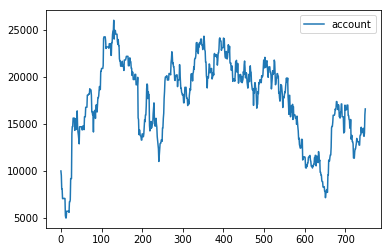

In [112]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains[gold_gains.index > '2016-01-01'], gold_validate, gold_label_validate, xgb_use=True)
gold_account.plot()

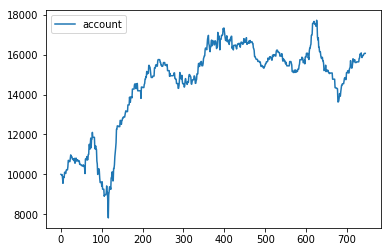

In [51]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains[corn_gains.index > '2016-01-01'], corn_validate, corn_label_validate, xgb_use=corn_xgb_use)
corn_account.plot()

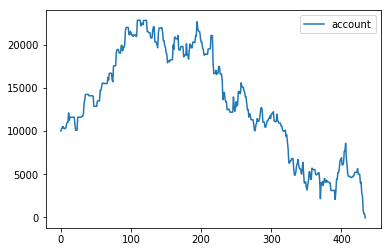

In [52]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains[coffee_gains.index > '2016-01-01'], coffee_validate, coffee_label_validate, xgb_use=True)
coffee_account.plot()